# Applied Machine Learning Mini Project
## Introduction
This miniproject focuses on applying machine learning techniques to solve a classification problem, starting with exploring an preparing the dataset.

The process begins with data preprocessing, including gandling missing values and scaling features, to ensure the models perform optimally. Two widely used algorithms, Support Vector Machines and Random Forest Classifier will be trained on the data and evaluated for their effectiveness.
Various evaluation metrics, performance curves and precision recall , will help assess and compare the models accuracy and reliability, confusion metrics, ROC curve and Precision-recall curve will be used to better understand the results and provide insights into how the models perform.

## Objectives

1. Load and explore the dataset.
2. Preprocess the data, including handling missing values and scaling features.
3. Split the data into training and testing sets.
4. Train the SVM model.
5. Train a Random Forest Classifier
6. Evaluate the model using various metrics such as confusion matrix, classification report, ROC curve, and precision-recall curve.
7. Visualize the results to gain insights into the model's performance.

# Model Choice 
Different models where tried without implementin DecisionTreeClassifier and Logistic Regressions.  
The implemented models for this task are Random forest and Support Vector Machines as shown below because based on a test they proved to be more promissing:


## Random forest 

Random forest is a machine learning method that Combines multiple decision trees to make better prediction then with a single decision tree which gives it mutiple advantages.

These advantages for use of Random forest is as follows: 
1. Different models where tested and random forest outperformed other especially Logistic Regression which may be because the data does not have a linear relation. 
2. Its ensemble approach helps prevent overfitting and makes it more resilient to noise, leading to improved generalization and accuracy thanks to the combination of mutiple decission trees. 
3. This model can calculate the "weight/importance" of each variable/feature when it's making predictions, therefor it can for an example be used to detect "key features/variables" that can lead to a machine faliure.



## Support Vector Machines (SVM)

Support Vector Machines (SVM) is a supervised machine learning algorithm model used for either classification or regression tasks.
What this model does is that SVM can seperate data into different classes by linear classification, non-linear classfication or support vectors. 

Reason for the choice of SVM are as follows: 
1. SVMs are effective in datasets with non-linear relationships.
2. SVM can help address imbalanced datasets, improving performance on minority classes.
3. Good for high dimensional data.
4. clear margin of sperations data (like failure or nor a failure).


First the needed dependencies are loaded, and this includes the models and the packages used to validate.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from imblearn.under_sampling import RandomUnderSampler

The dataset is loaded and checked for missing values, along with differences in the data. 

In [2]:
# Load the dataset
df = pd.read_csv('ai4i2020.csv')

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Check the number of ones vs zeroes in the column 'Machine failure'
# This is to check if the dataset is balanced or imbalanced
machine_failure_counts = df['Machine failure'].value_counts()
print("\nNumber of ones vs zeroes in 'Machine failure' column:\n", machine_failure_counts)

Missing values in each column:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Number of ones vs zeroes in 'Machine failure' column:
 Machine failure
0    9661
1     339
Name: count, dtype: int64


The following block of code first defines the target and features of the dataset by dropping the variables that do not include features for the machines. The data is then split into 80% training and 20% testing sets. RandomUnderSampler is used to balance the dataset so that there is an equal number of positive and negative samples. Tests have also been conducted with SMOTE, which is why it is commented out. The same goes for the scalar function, which is used to normalize the values. 

In [3]:
X = df.drop(columns=['Machine failure', 'Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'UDI'])
y = df['Machine failure']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Random Under Sampler to the training set
undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

print("The data is now evenly spread", len(X_train), len(y_train))

# Smote the training set to balance the dataset, adding more samples to
# the minority class based on the existing samples
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale the feature variables
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

The data is now evenly spread 556 556


Grid search is implemented with crossvalidation to find the best model combination. 
For the RandomForestClassifier the hyperprarameters are as followed: 
### Hyperparameters:

- **`n_estimators`:** `[50, 100, 200]`  
  The number of trees in the forest.  
  - Higher values can improve performance but increase computational cost.

- **`max_depth`:** `[None, 10, 20, 30]`  
  The maximum depth of the tree.  
  - Limits the number of levels in each decision tree.  
  - `None` means nodes are expanded until all leaves are pure or contain fewer than `min_samples_split` samples.

- **`min_samples_split`:** `[2, 5, 10]`  
  The minimum number of samples required to split an internal node.  
  - Higher values prevent the model from learning overly specific patterns (overfitting).

- **`min_samples_leaf`:** `[1, 2, 4]`  
  The minimum number of samples required to be at a leaf node.  
  - Higher values prevent the model from learning overly specific patterns (overfitting).

- **`class_weight`:** `['balanced', None]`  
  Weights associated with classes to handle class imbalance.  
  - `'balanced'` uses the values of `y` to automatically adjust weights inversely proportional to class frequencies.  
  - `None` means all classes are supposed to have weight one.


In [4]:
def grid_search_cv(X_train, y_train):
    # Define the hyperparameters to tune
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', None]
    }
    
    # Create the RandomForestClassifier model
    # cv is the number of folds in the cross-validation
    # n_jobs is the number of jobs to run in parallel -1 means using all processors
    # f1 scoring is the metric to use to evaluate the model
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring='f1'
    )
    
    # Precision: Precision = 50 / (50 + 5) = 50 / 55 ≈ 0.91
    # Recall: Recall = 50 / (50 + 10) = 50 / 60 ≈ 0.83
    # F1 Score: F1 Score = 2 * (0.91 * 0.83) / (0.91 + 0.83) ≈ 0.87
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    duration = time.time() - start_time
    
    return grid_search.best_estimator_, (grid_search.best_params_, grid_search.best_score_, duration)

# The hyperparameters found are implemented so training is faster and the results are saved.
# When training for different changes in the dataset the gridsearch is used.

# RandomForestClassifier model with specified hyperparameters
rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=50,
    random_state=42
)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Use this to see results of the grid search
#grid_result, returns = grid_search_cv(X_train, y_train)
#print(returns)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                       random_state=42)

 ## Model Evaluation and Insights

This code provides evaluation of the model, covering its performance and interpretability. Here's what each section reveals:

---

1. **Cross-Validation (`cv_score`)**
   - What it shows: The F1 scores from a 5-fold cross-validation on the training set.
   - Purpose: Evaluates model performance consistency across different data splits, providing an estimate of how well the model generalizes.


2. **Classification Report**
   - What it shows: Precision, recall, F1-score, and support for each class.
   - Purpose: Summarizes model performance per class, helping identify strengths and weaknesses in distinguishing between classes.


3. **Confusion Matrix**
   - What it shows: A heatmap of true vs. predicted labels.
   - Purpose: Highlights the number of correct and incorrect predictions for each class, revealing specific types of errors.


4. **ROC Curve**
   - What it shows: The trade-off between the true positive rate (TPR) and the false positive rate (FPR) at different thresholds. Includes the Area Under Curve (AUC).
   - Purpose: Evaluates the model's ability to distinguish between classes across thresholds. AUC close to 1 indicates strong performance.


5. **Precision-Recall Curve**
   - What it shows: The trade-off between precision and recall at different thresholds.
   - Purpose: Especially useful for imbalanced datasets, focusing on the model's ability to retrieve relevant instances.

6. **Feature Importances**
   - What it shows: The relative importance of each feature in making predictions.
   - Purpose: Provides insights into which features have the most impact on the model's decisions, aiding interpretability and feature selection.



Cross-validation F1 score: [0.94642857 0.93577982 0.89473684 0.84955752 0.92307692]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1939
           1       0.24      0.95      0.39        61

    accuracy                           0.91      2000
   macro avg       0.62      0.93      0.67      2000
weighted avg       0.98      0.91      0.93      2000



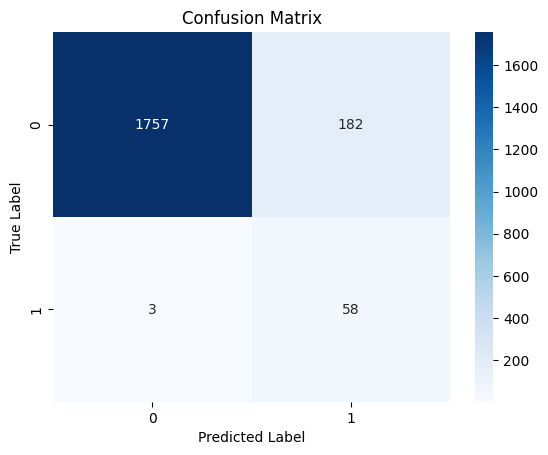

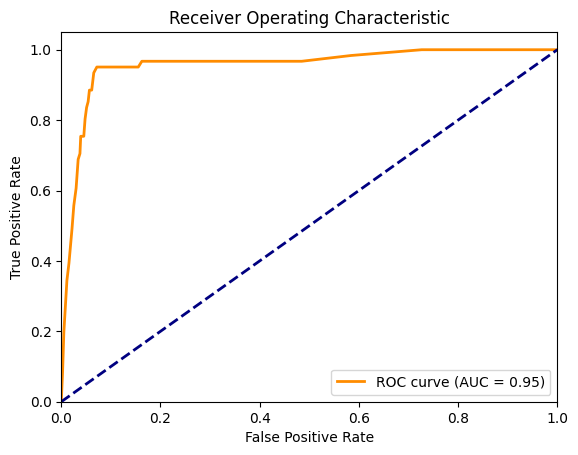

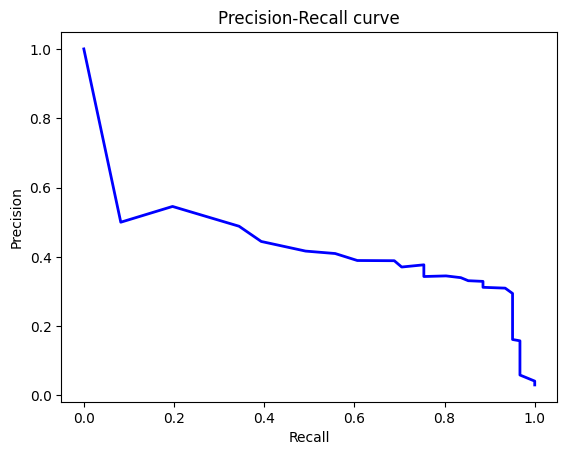

                   Feature  Importance
2   Rotational speed [rpm]    0.333578
3              Torque [Nm]    0.266517
4          Tool wear [min]    0.239395
0      Air temperature [K]    0.090302
1  Process temperature [K]    0.070208


In [5]:
# Cross-validation 
cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
print("Cross-validation F1 score:", cv_score)

# Make predictions on the test set
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


# Get feature importances from the model
feature_importances = rf.feature_importances_
feature_names = X.columns  # Ensure feature names are taken from the correct DataFrame

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importances_df)


These are the hyperparameters used for SVM implemented the same way as RF:

### Hyperparameters for SVM:

- **`C`:** `[0.01, 0.1, 1, 10, 100]`  
  The regularization parameter.  
  - A large C value prioritizes correct classification of the training points, even at the expense of a smaller margin. The decision boundary may adjust itself closely around data points to avoid errors, effectively reducing the margin distance. 

- **`kernel`:** `['linear', 'rbf', 'poly']`  
  The kernel type used in the algorithm.  
  - `'linear'`: Uses a linear hyperplane.  
  - `'rbf'`: Maps inputs to a higher-dimensional space using a Gaussian kernel.  
  - `'poly'`: Uses a polynomial kernel.



In [6]:
def grid_search_cv(X_train, y_train):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'class_weight': ['balanced', None]
    }
    
    # Create the RandomForestClassifier model
    # cv is the number of folds in the cross-validation
    # n_jobs is the number of jobs to run in parallel -1 means using all processors
    # f1 scoring is the metric to use to evaluate the model
    svm = SVC(probability=True, random_state=42)
    grid_search = GridSearchCV(
        svm,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1,
        scoring='f1'
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    duration = time.time() - start_time
    
    return grid_search.best_estimator_, (grid_search.best_params_, grid_search.best_score_, duration)


# Example usage

#grid_result, returns = grid_search_cv(X_train, y_train)

# Inputtet results from grid_search_cv
# Create the SVM model with specified hyperparameters
svm = SVC(C=100, class_weight=None, kernel='linear', probability=True, random_state=42)

# Fit the model on the training data
svm.fit(X_train, y_train)

#print("Best parameters found: ", returns[0])
#print("Best cross-validation score: ", returns[1])
#print("Duration of grid search: ", returns[2])

SVC(C=100, kernel='linear', probability=True, random_state=42)

The evaluation metrics for this model are the same as the ones from the other model as well. 

Cross-validation F1 score: [0.94642857 0.93577982 0.89473684 0.84955752 0.92307692]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      1939
           1       0.14      0.84      0.23        61

    accuracy                           0.83      2000
   macro avg       0.56      0.83      0.57      2000
weighted avg       0.97      0.83      0.89      2000



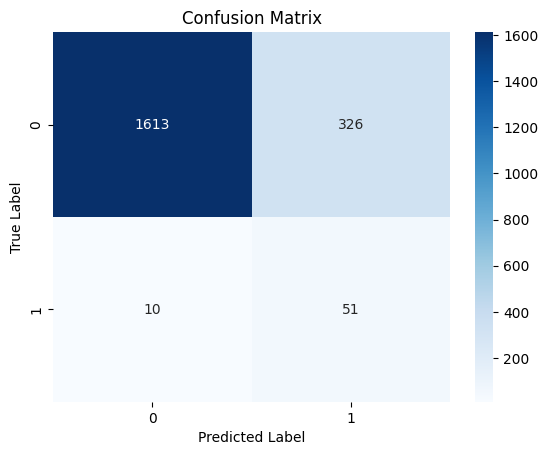

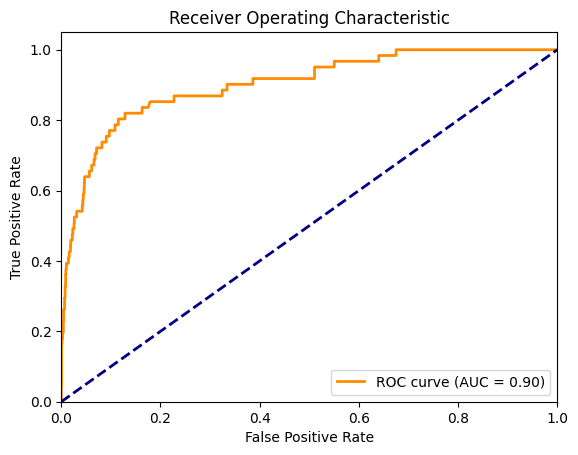

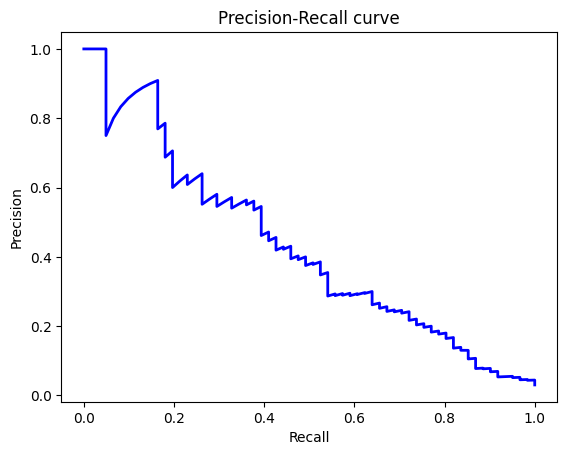

In [7]:
# Cross-validation 
cv_score = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1')
print("Cross-validation F1 score:", cv_score)

# Make predictions on the test set
y_pred = svm.predict(X_test)
y_pred_proba = svm.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()

## Conclusion
This project demonstrated the application of machine learning techniques to solve a classification problem, focusing on preprocessing, training, and evaluating models. By exploring and preparing the dataset, we ensured the data was ready for training the models. A Support Vector Machine model and a Random Forest Classifier were used to predict class labels, with their performance analyzed through various metrics and visualizations.

The preprocessing phase was crucial in preparing the dataset for analysis. Missing values were addressed and the data was tested with different, changes in the dataset. This includes Smote and RandomUnderSample. Splitting the data into training and testing sets ensured that the models were evaluated on unseen data, providing a realistic measure of their generalization ability.

The confusion matrix provided a straighfoward way to analize prediction accuracy by showing where the models succeded and where errors occured. The ROC curve offered insight into how well the SVM model balanced recall and sprecificity with a AUC = 0.9 which is indicates a fine performance. The precision recall curve highlighted trade-off between precision and recall, particularly in scenarios with imbalanced classes.

The ROC curve provided a detailed look at the models’ trade-offs between true positive and false positive rates. The Random Forest model demonstrated strong discriminatory power, as reflected in the area under the curve. Similarly, the precision-recall curve offered a focused perspective on the balance between precision and recall, which is particularly useful for datasets with uneven class distributions. The results here emphasized the importance of maintaining high recall for critical applications while avoiding a drop in precision. In the context of machine failure prediction, higher recall is often preferred because it ensures that most potential failures are detected, allowing for preventive maintenance and reducing the risk of unexpected breakdowns. However, the specific preference between recall and precision depends on the consequences of false positives and false negatives in the particular application.

The Random Forest Classifier complemented the SVM by leveraging its ability to capture complex, nonlinear relationships between features and target variables. While SVM relies on hyperplanes for decision boundaries, Random Forest’s approach enabled it to handle the data more robustly, at the cost of less  interpretability. 

When evaluating the models on the test set, the overall accuracy was 91% demonstrating strong predictive power. However the breakdown of precision, recall, and F1 scores provided deeper insights into the model`s strenghts and weaknesses. 

In the no machine failure class the model performed well, achieving a precision of 1.00, recall of 0.91, and an F1 score of 0.95. This indicates that the model was confident and accurate when predicting the majority class, making very few false positives or negatives, but, regarding the machine failure class the model struggled, achieving a precision of 0.24 and a recall of 0.95, resulting in an F1 score of 0.39. While the high recall suggests that the model was able to correctly identify most true positives for this class, the low precision indicates a high number of false positives. This trade-off could be attributed to the severe imbalance in the dataset, where the machine failure class accounted for only 61 out of 2000 samples.

The results emphasize the challenges of handling imbalanced datasets. While the model performed well overall, its limited precision for the minority class could have critical implications in real-world applications where a high amount of false positives is not desired.

Future enhaancments could include experimenting with additional algorithms, refining hyperparametrs, or addressing imbalanced datasets to further optimize results.

